In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import datetime as dt

from pybaseball import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import psycopg2
import pandas.io.sql as psql
from sqlalchemy import create_engine

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df_18 = pd.read_pickle('../pickles/2018_games_labeled_1.pkl')
df_17 = pd.read_pickle('../pickles/2017_games_labeled_1.pkl')
df_16 = pd.read_pickle('../pickles/2016_games_labeled_1.pkl')
df_15 = pd.read_pickle('../pickles/2015_games_labeled_1.pkl')
merge = pd.read_pickle('../pickles/labeled_games_agg.pkl')
total = pd.read_pickle('../pickles/labeled_games_agg_sc.pkl')

In [3]:
df_18.head()

,#days,2b,3b,ab,age,appearance_yr,babip,bb,bf,cs,date,days,days_preceeding,days_rest,enddate,er,era,first_x,first_y,g,gb/fb,gdp,gs,h,hbp,hr,ibb,injured?,injury,ip,key_bbref_x,key_bbref_y,key_fangraphs_x,key_fangraphs_y,key_mlbam,key_retro_x,key_retro_y,l,last_x,last_y,ld,lev,list,mlb_played_first_x,mlb_played_first_y,mlb_played_last_x,mlb_played_last_y,moneyearned,name_first_x,name_first_y,name_last_x,name_last_y,name_x,name_y,pit,po,posititon,pu,r,sb,sf,so,so/w,so9,startdate,stl,str,sts,sv,team,tm,w,whip,year
95,368.0,0.0,0.0,23.0,45.0,1,0.333,1.0,24.0,0.0,2018-04-02,9.0,144,182.0,9/1,1.0,1.50,bartolocolon,bartolo,1.0,0.55,1.0,1.0,7.0,0.0,1.0,0.0,0.0,Back,6.0,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.10,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,89.0,0.0,SP,0.05,1.0,0.0,0.0,4.0,4.0,6.0,2018-08-24,0.21,0.70,0.07,NaN,TEX,Texas,NaN,1.333,2018.0
96,362.0,0.0,0.0,7.0,45.0,2,0.333,0.0,7.0,0.0,2018-04-08,9.0,138,6.0,9/1,0.0,0.00,bartolocolon,bartolo,1.0,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Back,2.0,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.00,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,29.0,0.0,SP,0.00,0.0,0.0,0.0,4.0,NaN,18.0,2018-08-24,0.24,0.72,0.14,NaN,TEX,Texas,NaN,0.500,2018.0
97,360.0,0.0,0.0,9.0,45.0,3,0.250,0.0,10.0,0.0,2018-04-10,9.0,136,2.0,9/1,1.0,3.00,bartolocolon,bartolo,1.0,0.38,0.0,0.0,2.0,0.0,0.0,0.0,0.0,Back,3.0,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.25,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,29.0,0.0,SP,0.00,1.0,0.0,1.0,2.0,NaN,6.0,2018-08-24,0.14,0.66,0.10,NaN,TEX,Texas,NaN,0.667,2018.0
98,355.0,1.0,0.0,23.0,45.0,4,0.059,1.0,25.0,0.0,2018-04-15,9.0,131,5.0,9/1,1.0,1.17,bartolocolon,bartolo,1.0,0.59,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Back,7.2,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.18,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,96.0,0.0,SP,0.00,1.0,0.0,1.0,7.0,7.0,8.2,2018-08-24,0.24,0.69,0.08,NaN,TEX,Texas,NaN,0.261,2018.0
99,349.0,0.0,0.0,22.0,45.0,5,0.300,1.0,25.0,1.0,2018-04-21,9.0,125,6.0,9/1,4.0,6.35,bartolocolon,bartolo,1.0,0.52,0.0,1.0,7.0,1.0,1.0,0.0,0.0,Back,5.2,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.24,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,85.0,0.0,SP,0.00,4.0,0.0,1.0,2.0,2.0,3.2,2018-08-24,0.21,0.69,0.08,NaN,TEX,Texas,NaN,1.412,2018.0


In [4]:
sc_18 = pd.read_pickle('../pickles/sc_2018_unclean.pkl')
sc_17 = pd.read_pickle('../pickles/sc_2017_unclean.pkl')
sc_16 = pd.read_pickle('../pickles/sc_2016_unclean.pkl')
sc_15 = pd.read_pickle('../pickles/sc_2015_unclean.pkl')
total = sc_18.append([sc_17, sc_16, sc_15])
total = total.sort_values(by=['key_mlbam', 'date'])
total = total.set_index(np.arange(len(total)))
# total.to_pickle('../pickles/labeled_games_agg_sc.pkl')

In [5]:
drop = ['#days', '2b', '3b', 'ab', 'babip', 'bf', 'cs', 'date', 'days', 'days_preceeding', 'enddate', 'era', 'first_x', 'first_y', 'g', 'gb/fb', 'gdp', 'gs', 'ibb', 'injury', 'key_bbref_x', 'key_bbref_y', 'key_fangraphs_x', 'key_fangraphs_y', 'key_mlbam', 'key_retro_x', 'key_retro_y', 'l', 'last_x', 'last_y', 'ld', 'lev', 'list', 'mlb_played_first_y', 'mlb_played_last_x', 'mlb_played_last_y', 'moneyearned', 'name_first_x', 'name_first_y', 'name_last_x', 'name_last_y', 'name_x', 'name_y', 'po', 'posititon', 'pu', 'sb', 'sf', 'so/w', 'startdate', 'stl', 'sts', 'sv', 'team', 'tm', 'year']

In [6]:
# X = total.drop(columns=drop)
# X = X.replace([np.inf, -np.inf], np.nan)
# X

In [7]:
# X = X[X['fb_count'].notnull() | X['os_count'].notnull()]
# X['w'] = X['w'].fillna(0)
# X

In [8]:
# len(X[X['p_throws_x'].isnull() & X['p_throws_y'].isnull()])

In [9]:

X = total.drop(columns=drop)
X = X.replace([np.inf, -np.inf], np.nan)
X = X[X['fb_count'].notnull() | X['os_count'].notnull()]
X['p_throws_x'] = X['p_throws_x'].fillna(X['p_throws_y'])
X = X.drop(columns='p_throws_y')
X = X.fillna(0)


In [192]:
# X.to_pickle('../pickles/X_ugly.pkl')
X = pd.read_pickle('../pickles/X_ugly.pkl')
X

,age,appearance_yr,bb,days_rest,er,h,hbp,hr,injured?,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement,L,R
0,42.0,1,1.0,182.0,1.0,3.0,0.0,1.0,0.0,6.0,1997.0,86.0,1.0,8.0,12.0,0.69,1.0,0.667,0.883721,89.784211,88.202553,2280.710526,-1.481718,5.916537,5.605737,-1.026215,1.276848,0.116279,83.540000,81.596556,2469.444444,-1.733989,5.992122,5.262667,0.046602,0.628567,0,1
1,42.0,2,0.0,6.0,3.0,6.0,0.0,1.0,0.0,7.0,1997.0,77.0,3.0,5.0,6.4,0.78,1.0,0.857,0.922078,88.569014,86.327366,2133.971831,-1.161156,5.956703,5.049437,-0.843298,1.237249,0.077922,82.000000,80.086500,1761.833333,-1.357450,6.000083,4.996000,-0.546108,0.733678,0,1
2,42.0,3,0.0,5.0,1.0,6.0,0.0,1.0,0.0,7.0,1997.0,91.0,1.0,5.0,6.4,0.73,1.0,0.857,0.835165,89.246053,87.101987,2193.346667,-1.295146,6.124792,5.372947,-1.087467,1.038179,0.164835,82.940000,80.848267,1817.461538,-1.520147,6.105167,5.204200,-0.449991,0.594358,0,1
3,42.0,4,0.0,6.0,3.0,7.0,0.0,0.0,0.0,6.0,1997.0,88.0,3.0,5.0,7.5,0.66,1.0,1.167,0.909091,89.025000,86.779882,2196.473684,-1.227378,6.096868,5.243171,-1.292720,1.116850,0.125000,81.936364,79.716000,2036.363636,-1.438264,6.180809,5.089818,-0.711843,0.584264,0,1
4,42.0,5,0.0,6.0,4.0,9.0,0.0,1.0,0.0,6.2,1997.0,91.0,4.0,2.0,2.7,0.70,0.0,1.350,0.791209,88.462500,86.099380,2192.563380,-0.902362,6.524101,5.158310,-1.210262,1.227521,0.186813,82.476471,79.931938,2331.312500,-1.208682,6.446600,4.900688,-0.017521,0.677131,0,1
5,42.0,6,0.0,6.0,1.0,6.0,0.0,1.0,0.0,7.2,1997.0,97.0,1.0,9.0,10.6,0.73,1.0,0.783,0.773196,88.473333,86.168562,2127.808219,-1.324715,6.090521,5.345877,-1.258029,0.782793,0.226804,82.859091,80.577182,2202.272727,-1.462559,6.199268,5.153591,-0.258982,0.475265,0,1
6,42.0,7,0.0,5.0,4.0,8.0,0.0,1.0,0.0,6.0,1997.0,92.0,4.0,6.0,9.0,0.75,1.0,1.333,0.858696,89.063291,87.144241,2178.227848,-1.085206,6.025118,5.298582,-1.327961,1.177207,0.141304,81.961538,79.916769,2060.400000,-1.185146,6.063846,5.134154,-0.592354,0.733200,0,1
7,42.0,8,0.0,5.0,5.0,7.0,0.0,2.0,0.0,5.0,1997.0,62.0,6.0,2.0,3.6,0.84,0.0,1.400,0.854839,88.739623,86.634673,2157.230769,-1.302373,6.049929,5.480269,-1.173514,0.945198,0.145161,82.277778,80.169444,1939.000000,-1.478622,6.120133,5.217000,-0.370140,0.578719,0,1
8,42.0,9,2.0,5.0,8.0,11.0,0.0,2.0,0.0,4.1,1997.0,86.0,9.0,4.0,8.3,0.67,0.0,3.000,0.895349,88.153247,85.228267,2104.106667,-1.273736,6.117139,5.266947,-1.548687,0.911157,0.104651,82.188889,79.144556,1953.444444,-1.331844,6.122100,5.142444,-0.389005,0.730652,0,1
9,42.0,10,2.0,5.0,3.0,6.0,0.0,0.0,0.0,6.0,1997.0,94.0,3.0,6.0,9.0,0.71,1.0,1.333,0.882979,89.295181,86.799566,2101.036145,-1.074642,5.850949,5.182325,-1.106246,0.929152,0.106383,82.580000,80.441200,1919.100000,-1.193300,5.769790,5.173700,-0.645891,0.725890,0,1


In [73]:
y = pro.pop('injured?')

In [187]:
# dummies = pd.get_dummies(X['p_throws_x'])
# dummies

In [188]:
# X = pd.concat([X, dummies], axis=1)

In [189]:
# # X = X.drop(columns='p_throws_x')
# X['fb_count'] = X['fb_count']/X['pit']
# X['os_count'] = X['os_count']/X['pit']
# X = X.replace([np.inf, -np.inf], np.nan)
# X = X.fillna(0)

In [11]:
y = X.pop('injured?')

In [191]:
X

,age,appearance_yr,bb,days_rest,er,h,hbp,hr,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement,L,R
0,42.0,1,1.0,182.0,1.0,3.0,0.0,1.0,6.0,1997.0,86.0,1.0,8.0,12.0,0.69,1.0,0.667,0.883721,89.784211,88.202553,2280.710526,-1.481718,5.916537,5.605737,-1.026215,1.276848,0.116279,83.540000,81.596556,2469.444444,-1.733989,5.992122,5.262667,0.046602,0.628567,0,1
1,42.0,2,0.0,6.0,3.0,6.0,0.0,1.0,7.0,1997.0,77.0,3.0,5.0,6.4,0.78,1.0,0.857,0.922078,88.569014,86.327366,2133.971831,-1.161156,5.956703,5.049437,-0.843298,1.237249,0.077922,82.000000,80.086500,1761.833333,-1.357450,6.000083,4.996000,-0.546108,0.733678,0,1
2,42.0,3,0.0,5.0,1.0,6.0,0.0,1.0,7.0,1997.0,91.0,1.0,5.0,6.4,0.73,1.0,0.857,0.835165,89.246053,87.101987,2193.346667,-1.295146,6.124792,5.372947,-1.087467,1.038179,0.164835,82.940000,80.848267,1817.461538,-1.520147,6.105167,5.204200,-0.449991,0.594358,0,1
3,42.0,4,0.0,6.0,3.0,7.0,0.0,0.0,6.0,1997.0,88.0,3.0,5.0,7.5,0.66,1.0,1.167,0.909091,89.025000,86.779882,2196.473684,-1.227378,6.096868,5.243171,-1.292720,1.116850,0.125000,81.936364,79.716000,2036.363636,-1.438264,6.180809,5.089818,-0.711843,0.584264,0,1
4,42.0,5,0.0,6.0,4.0,9.0,0.0,1.0,6.2,1997.0,91.0,4.0,2.0,2.7,0.70,0.0,1.350,0.791209,88.462500,86.099380,2192.563380,-0.902362,6.524101,5.158310,-1.210262,1.227521,0.186813,82.476471,79.931938,2331.312500,-1.208682,6.446600,4.900688,-0.017521,0.677131,0,1
5,42.0,6,0.0,6.0,1.0,6.0,0.0,1.0,7.2,1997.0,97.0,1.0,9.0,10.6,0.73,1.0,0.783,0.773196,88.473333,86.168562,2127.808219,-1.324715,6.090521,5.345877,-1.258029,0.782793,0.226804,82.859091,80.577182,2202.272727,-1.462559,6.199268,5.153591,-0.258982,0.475265,0,1
6,42.0,7,0.0,5.0,4.0,8.0,0.0,1.0,6.0,1997.0,92.0,4.0,6.0,9.0,0.75,1.0,1.333,0.858696,89.063291,87.144241,2178.227848,-1.085206,6.025118,5.298582,-1.327961,1.177207,0.141304,81.961538,79.916769,2060.400000,-1.185146,6.063846,5.134154,-0.592354,0.733200,0,1
7,42.0,8,0.0,5.0,5.0,7.0,0.0,2.0,5.0,1997.0,62.0,6.0,2.0,3.6,0.84,0.0,1.400,0.854839,88.739623,86.634673,2157.230769,-1.302373,6.049929,5.480269,-1.173514,0.945198,0.145161,82.277778,80.169444,1939.000000,-1.478622,6.120133,5.217000,-0.370140,0.578719,0,1
8,42.0,9,2.0,5.0,8.0,11.0,0.0,2.0,4.1,1997.0,86.0,9.0,4.0,8.3,0.67,0.0,3.000,0.895349,88.153247,85.228267,2104.106667,-1.273736,6.117139,5.266947,-1.548687,0.911157,0.104651,82.188889,79.144556,1953.444444,-1.331844,6.122100,5.142444,-0.389005,0.730652,0,1
9,42.0,10,2.0,5.0,3.0,6.0,0.0,0.0,6.0,1997.0,94.0,3.0,6.0,9.0,0.71,1.0,1.333,0.882979,89.295181,86.799566,2101.036145,-1.074642,5.850949,5.182325,-1.106246,0.929152,0.106383,82.580000,80.441200,1919.100000,-1.193300,5.769790,5.173700,-0.645891,0.725890,0,1


In [194]:
X_train, X_test, y_train, y_test = train_test_split(pro, y, test_size=0.33, random_state=42)

In [195]:
from imblearn.over_sampling import SMOTE

In [196]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [156]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10),
    'class_weight': ['balanced', None]
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, scoring='roc_auc', cv=3, verbose=5, n_jobs=-1)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=1.0, class_weight=balanced ....................................
[CV] C=1.0, class_weight=balanced ....................................
[CV] C=1.0, class_weight=balanced ....................................
[CV] C=1.0, class_weight=None ........................................
[CV] C=1.0, class_weight=None ........................................
[CV] C=1.0, class_weight=None ........................................
[CV] C=2.0, class_weight=balanced ....................................
[CV] C=2.0, class_weight=balanced ....................................
[CV] C=2.0, class_weight=balanced ....................................
[CV] C=2.0, class_weight=None ........................................
[CV] C=2.0, class_weight=None ........................................
[CV] C=2.0, class_weight=None ........................................
[CV]  C=1.0, class_weight=balanced, score=0.7140667119208884, total=   6.2s
[CV] C=3.0,

[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:   41.1s remaining:    8.2s


[CV]  C=9.0, class_weight=None, score=0.7141068219798603, total=   7.2s
[CV]  C=9.0, class_weight=None, score=0.7149278126249696, total=   6.9s
[CV]  C=10.0, class_weight=balanced, score=0.7141328722715001, total=   6.1s
[CV]  C=10.0, class_weight=None, score=0.7141328722715001, total=   5.8s
[CV]  C=9.0, class_weight=None, score=0.7187010865167106, total=   7.7s
[CV]  C=10.0, class_weight=balanced, score=0.7187116513572089, total=   6.6s
[CV]  C=10.0, class_weight=None, score=0.7187116513572089, total=   6.2s
[CV]  C=10.0, class_weight=balanced, score=0.7149634208486723, total=   6.6s
[CV]  C=10.0, class_weight=None, score=0.7149634208486723, total=   5.8s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   43.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [157]:
clf.best_params_

{'C': 10.0, 'class_weight': 'balanced'}

In [203]:
lr1 = LogisticRegression(C=5, class_weight='balanced', n_jobs=-1)
lr1.fit(X_train_res, y_train_res.ravel())

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [204]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 61.564625850340136%
Precision metric in the train dataset: 99.38247991693535%
Accuracy metric in the train dataset: 67.21314474960204%


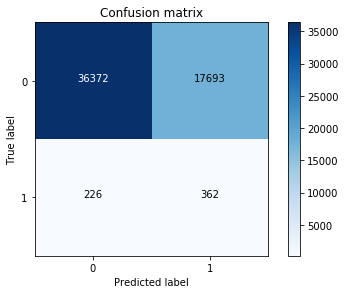

In [205]:
y_train_pre = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
print("Precision metric in the train dataset: {}%".format(100*cnf_matrix_tra[0,0]/(cnf_matrix_tra[0,0]+cnf_matrix_tra[1,0])))
print("Accuracy metric in the train dataset: {}%".format(100*(cnf_matrix_tra[0,0] + cnf_matrix_tra[1,1])/(cnf_matrix_tra[0,0]+cnf_matrix_tra[1,1]+cnf_matrix_tra[0,1]+cnf_matrix_tra[1,0])))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 58.333333333333336%
Precision metric in the testing dataset: 99.33949801849406%
Accuracy metric in the testing dataset: 67.6696756937479%


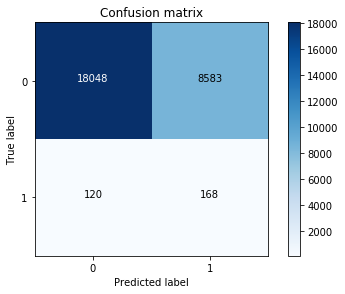

In [206]:
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
print("Accuracy metric in the testing dataset: {}%".format(100*(cnf_matrix[0,0] + cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[0,1]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [207]:
# tmp = lr1.fit(X_train_res, y_train_res.ravel())

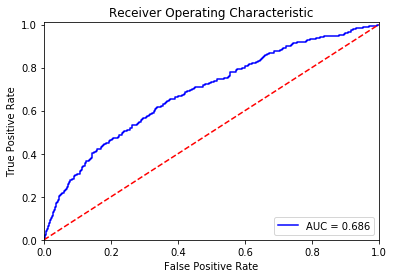

In [208]:
y_pred_sample_score = lr1.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [144]:
scaler = StandardScaler()

In [193]:
pro_std = scaler.fit_transform(pro)

In [209]:
rf = RandomForestClassifier(n_estimators = 300, class_weight='balanced', n_jobs=-1, oob_score=True, max_depth=3, max_features='sqrt')

In [210]:
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [211]:
y_pred = rf.predict(X_test)

In [212]:
print(len(X_train_res))
print(len(y_train_res))
y_pred.sum()

108130
108130


7828.0

Recall metric in the train dataset: 52.55102040816327%
Precision metric in the training dataset: 99.27938631608853%
Accuracy metric in the training dataset: 70.89638263224343%


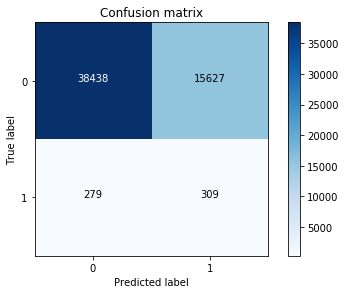

In [213]:
y_train_pre = rf.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
print("Precision metric in the training dataset: {}%".format(100*cnf_matrix_tra[0,0]/(cnf_matrix_tra[0,0]+cnf_matrix_tra[1,0])))
print("Accuracy metric in the training dataset: {}%".format(100*(cnf_matrix_tra[0,0] + cnf_matrix_tra[1,1])/(cnf_matrix_tra[0,0]+cnf_matrix_tra[1,1]+cnf_matrix_tra[0,1]+cnf_matrix_tra[1,0])))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 53.125%
Precision metric in the testing dataset: 99.29286051018805%
Accuracy metric in the testing dataset: 70.98703517961292%


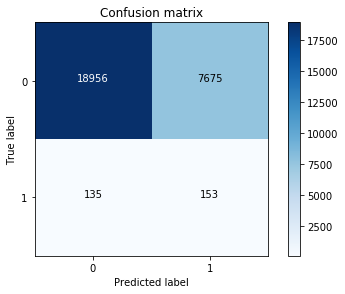

In [214]:
# y_pred = rf.predict(X_test)

cnf_matrix_rf = confusion_matrix(y_test, y_pred)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix_rf[1,1]/(cnf_matrix_rf[1,0]+cnf_matrix_rf[1,1])))
print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix_rf[0,0]/(cnf_matrix_rf[0,0]+cnf_matrix_rf[1,0])))
print("Accuracy metric in the testing dataset: {}%".format(100*(cnf_matrix_rf[0,0] + cnf_matrix_rf[1,1])/(cnf_matrix_rf[0,0]+cnf_matrix_rf[1,1]+cnf_matrix_rf[0,1]+cnf_matrix_rf[1,0])))
# {tp+tn}/{tp+tn+fp+fn}}
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rf , classes=class_names, title='Confusion matrix')
plt.show()

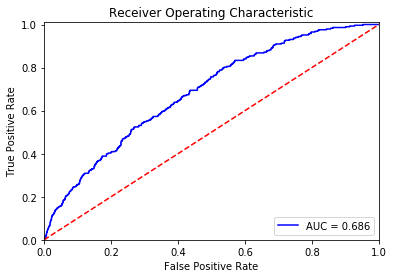

In [215]:
y_pred_sample_score_rf = rf.predict_proba(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score_rf[:, 1])

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [179]:
rf.predict_proba(X_test)[:, 1]

array([0.30772036, 0.53819186, 0.35696783, ..., 0.44467735, 0.24081607,
       0.45335769])

In [213]:
param_grid = {
    'max_depth': [2, 3, 5],
    'max_features': [2, 3, 'auto', 'sqrt'],
    
}

rf2 = RandomForestClassifier(n_estimators = 500, class_weight='balanced')
clf2 = GridSearchCV(rf2, param_grid, scoring='recall_weighted', cv=5, verbose=5, n_jobs=-1)
clf2.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=auto ..................................
[CV] max_depth=2, max_features=auto ..................................
[CV]  max_depth=2, max_features=2, score=0.7753584705257568, total=  34.1s
[CV] max_dep

[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:  6.3min remaining:  1.3min


[CV]  max_depth=5, max_features=auto, score=0.8700654983182864, total= 2.7min
[CV]  max_depth=5, max_features=auto, score=0.8813506815365552, total= 2.6min
[CV]  max_depth=5, max_features=auto, score=0.8818270337257679, total= 2.5min
[CV]  max_depth=5, max_features=auto, score=0.8842613083119413, total= 2.5min
[CV]  max_depth=5, max_features=auto, score=0.8810746215809507, total= 2.4min
[CV]  max_depth=5, max_features=sqrt, score=0.8700654983182864, total= 2.4min
[CV]  max_depth=5, max_features=sqrt, score=0.8813506815365552, total= 2.4min
[CV]  max_depth=5, max_features=sqrt, score=0.8818270337257679, total= 2.2min
[CV]  max_depth=5, max_features=sqrt, score=0.8810746215809507, total= 2.2min
[CV]  max_depth=5, max_features=sqrt, score=0.8842613083119413, total= 2.2min


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 5], 'max_features': [2, 3, 'auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall_weighted', verbose=5)

In [214]:
clf2.best_params_

{'max_depth': 5, 'max_features': 'auto'}

In [216]:
rf.oob_score_


0.7816887080366226

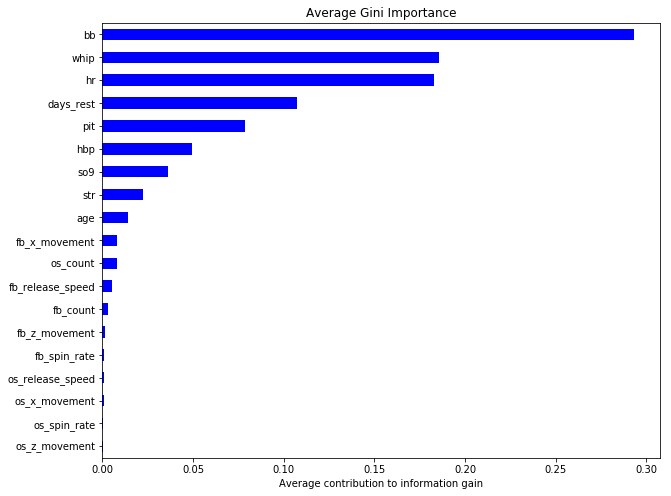

In [217]:
feat_scores = pd.Series(rf.feature_importances_,
                           index=pro.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

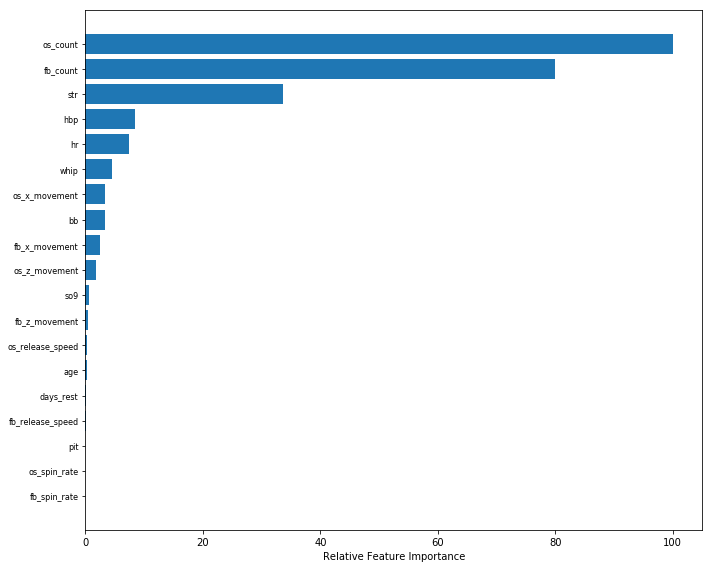

In [218]:
feature_importance = abs(lr1.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,8))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(pro.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [191]:
lr1.coef_[0]

array([ 2.74725866e-02,  9.10631445e-02, -4.23424749e-03,  3.85662170e-01,
        3.82962277e-01,  2.95565674e-03, -4.03241917e-02, -1.25444157e+00,
        2.54764969e-01,  1.80781776e+00, -3.50213767e-03,  1.67263253e-04,
       -9.52180169e-02,  9.53114396e-02,  2.51104231e+00, -5.29525699e-03,
       -6.83878767e-06, -4.71560332e-02, -4.38966382e-02])

In [146]:
drop

['#days',
 '2b',
 '3b',
 'ab',
 'babip',
 'bf',
 'cs',
 'date',
 'days',
 'days_preceeding',
 'enddate',
 'era',
 'first_x',
 'first_y',
 'g',
 'gb/fb',
 'gdp',
 'gs',
 'ibb',
 'injury',
 'key_bbref_x',
 'key_bbref_y',
 'key_fangraphs_x',
 'key_fangraphs_y',
 'key_mlbam',
 'key_retro_x',
 'key_retro_y',
 'l',
 'last_x',
 'last_y',
 'ld',
 'lev',
 'list',
 'mlb_played_first_y',
 'mlb_played_last_x',
 'mlb_played_last_y',
 'moneyearned',
 'name_first_x',
 'name_first_y',
 'name_last_x',
 'name_last_y',
 'name_x',
 'name_y',
 'po',
 'posititon',
 'pu',
 'sb',
 'sf',
 'so/w',
 'startdate',
 'stl',
 'sts',
 'sv',
 'team',
 'tm',
 'year']

In [68]:
# pro = total.drop(columns=drop)
drop_more = ['so', 'L', 'R', 'appearance_yr', 'ip', 'mlb_played_first_x', 'w', 'fb_percieved_speed', 'fb_avg_z', 'fb_avg_extension', 'fb_avg_x', 'os_percieved_speed', 'os_avg_x', 'os_avg_z', 'os_avg_extension']

pro = X
# pro = pro.replace([np.inf, -np.inf], np.nan)
# pro['p_throws_x'] = pro['p_throws_x'].fillna(pro['p_throws_y'])
# pro = pro.drop(columns='p_throws_y')
# pro = pro.fillna(0)
pro = pro.drop(columns=drop_more)

In [126]:
pro = pro.drop(columns='er')

In [13]:
pro['fb_count'] = pro['fb_count']/pro['pit']

In [14]:
pro['os_count'] = pro['os_count']/pro['pit']

In [15]:
pro = pro.replace([np.inf, -np.inf], np.nan)
pro = pro.fillna(0)

In [71]:
pro['injured?'].sum()

876.0

In [152]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
30       0.0
31       0.0
32       0.0
33       0.0
34       0.0
35       0.0
36       0.0
37       0.0
38       0.0
39       0.0
40       0.0
41       0.0
42       0.0
43       0.0
44       0.0
45       0.0
46       0.0
47       0.0
48       0.0
49       0.0
50       0.0
51       0.0
52       0.0
53       0.0
54       0.0
55       0.0
56       0.0
57       0.0
58       0.0
59       0.0
60       0.0
61       0.0
62       0.0
63       0.0
64       0.0
65       0.0
66       0.0
67       0.0
68       0.0
69       0.0
70       0.0
71       0.0
72       0.0
73       0.0
74       0.0
75       0.0
76       0.0